In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [55]:
from sklearn.model_selection import GridSearchCV

In [18]:
from sklearn.model_selection import train_test_split, cross_val_score

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [6]:
link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(link, sep=';')

In [7]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
data.shape

(1599, 12)

In [43]:
data.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

1.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [15]:
X, y = data.iloc[:,:-1], data.iloc[:,-1]

In [19]:
models =[
            RandomForestClassifier(n_estimators=100),
            BaggingClassifier(n_estimators=100),
            DecisionTreeClassifier()
        ]

In [21]:
for model in models:
    print(model)
    %time cvs = cross_val_score(model, X, y, scoring='accuracy', cv=3).mean()
    print(cvs, '\n')

RandomForestClassifier()
CPU times: user 587 ms, sys: 11.8 ms, total: 599 ms
Wall time: 613 ms
0.5622263914946842 

BaggingClassifier(n_estimators=100)
CPU times: user 1.25 s, sys: 9.38 ms, total: 1.26 s
Wall time: 1.26 s
0.5553470919324578 

DecisionTreeClassifier()
CPU times: user 21.6 ms, sys: 138 µs, total: 21.8 ms
Wall time: 21.8 ms
0.4540337711069418 



2.Разделите выборку на обучающую и тестовую в отношении 70%/30%

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=242)

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



In [26]:
%%time
N = [10, 50, 100] + [n for n in range(200,5001,200)]
scores = []

for n in N:
    clf = RandomForestClassifier(n_estimators=int(n), n_jobs=-1)
    clf.fit(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    scores.append({'n':int(n), 'score_test':score_test})

CPU times: user 2min 37s, sys: 35.2 s, total: 3min 13s
Wall time: 1min 23s


In [27]:
scores

[{'n': 10, 'score_test': 0.65},
 {'n': 50, 'score_test': 0.7208333333333333},
 {'n': 100, 'score_test': 0.7},
 {'n': 200, 'score_test': 0.70625},
 {'n': 400, 'score_test': 0.7041666666666667},
 {'n': 600, 'score_test': 0.7166666666666667},
 {'n': 800, 'score_test': 0.7083333333333334},
 {'n': 1000, 'score_test': 0.6979166666666666},
 {'n': 1200, 'score_test': 0.7125},
 {'n': 1400, 'score_test': 0.7145833333333333},
 {'n': 1600, 'score_test': 0.7083333333333334},
 {'n': 1800, 'score_test': 0.70625},
 {'n': 2000, 'score_test': 0.7041666666666667},
 {'n': 2200, 'score_test': 0.7083333333333334},
 {'n': 2400, 'score_test': 0.7041666666666667},
 {'n': 2600, 'score_test': 0.7020833333333333},
 {'n': 2800, 'score_test': 0.7020833333333333},
 {'n': 3000, 'score_test': 0.7083333333333334},
 {'n': 3200, 'score_test': 0.70625},
 {'n': 3400, 'score_test': 0.70625},
 {'n': 3600, 'score_test': 0.70625},
 {'n': 3800, 'score_test': 0.7041666666666667},
 {'n': 4000, 'score_test': 0.7125},
 {'n': 4200, 

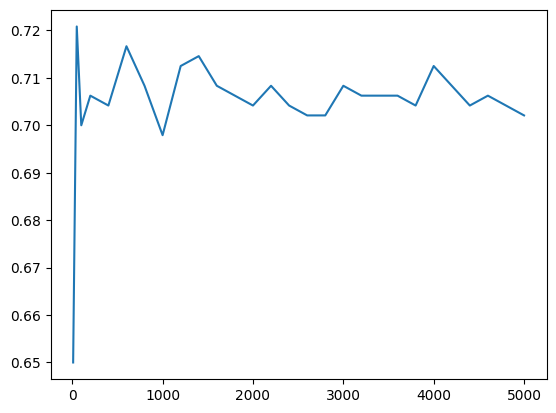

In [29]:
scores_df = pd.DataFrame(scores)

plt.plot(scores_df.n, scores_df.score_test)

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [44]:
boostings = [
                XGBClassifier(),
                GradientBoostingClassifier()
            ]

In [48]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [49]:
for boosting in boostings:
    print(boosting)
    %time cvs = cross_val_score(boosting, X, y, scoring='accuracy', cv=10).mean()
    print(cvs, '\n')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)
CPU times: user 31.6 s, sys: 4.69 s, total: 36.3 s
Wall time: 5.44 s
0.5547091194968552 

GradientBoostingClassifier()
CPU times: user 13.3 s, sys: 349 ms, total: 13.7 s
Wall time: 12.5 s
0.5622012578616353 



In [52]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

оптимизируемый функционал

скорость обучения - learning_rate  [1, 0.5, 0.25, 0.1, 0.05, 0.01]

количество деревьев - n_estimators [1, 2, 4, 8, 16, 32, 64, 100, 200]

глубина деревьев - max_deapth np.linspace(1, 32, 32, endpoint=True)

max_features = list(range(1,train.shape[1]))

Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.

In [68]:
params = {
            'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
            'n_estimators' : [1, 2, 4, 8, 16, 32],
            'max_depth' : range(1,10,1)
            }

In [70]:
for boosting in boostings:
    print(boosting)
    search = GridSearchCV(boosting, param_grid=params, scoring='accuracy', cv=3, n_jobs=-1).fit(X, y)
    print(search.best_params_)
    print(search.best_score_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 16}
0.5816135084427768
GradientBoostingClassifier()
{'learning_rate': 0.5, 'max_depth': 1, 'n_estimators': 32}
0.5741088180112571


6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов.
Сравните значение метрики accuracy и скорость по этим четырем реализациям.

8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [hyperopt](https://github.com/hyperopt/hyperopt) . Параметры для оптимизации:

оптимизируемый функционал

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.